In [4]:
# from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import torch
from torch import Tensor
from rich import print
import torch
from time import perf_counter
from typing import List, Union, Callable
import numpy as np
# from icecream import ic

from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer
import openai
import os


import matplotlib.pyplot as plt
# import mplcursors

%matplotlib ipympl

from utils import plot_2D, plot_heatmap
from dotenv import load_dotenv
load_dotenv()

from tenacity import retry, stop_after_attempt, wait_random_exponential


import google.generativeai as genai
import google.ai.generativelanguage as glm
from google.api_core import retry as gretry

from tqdm.auto import tqdm
import cohere
co = cohere.Client(os.environ['COHERE_API_KEY'])


In [5]:
from mistralai.client import MistralClient


In [4]:
openai.api_key = os.getenv('OPENAI_API_KEY')
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=GEMINI_API_KEY)
cohere_api_key = os.getenv("COHERE_API_KEY")
mistral_api_key = os.environ['MISTRAL_API_KEY']

# OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')


In [2]:
# test data for the exploration
in_1 = "Missing flamingo discovered at swimming pool"

in_2 = "Sea otter spotted on surfboard by beach"

in_3 = "Baby panda enjoys boat ride"

in_4 = "Breakfast themed food truck beloved by all!"

in_5 = "New curry restaurant aims to please!"

in_6 = "Python developers are wonderful people"

in_7 = "TypeScript, C++ or Java? All are great!"
input_text_lst_news = [in_1, in_2, in_3, in_4, in_5, in_6, in_7]


## Sentence Embedding with Bert

In [6]:
bert_model = BertModel.from_pretrained("bert-base-uncased")
def bert_sentence_embed(input_sentence: str, model: BertModel, word_ave: bool = True) -> Tensor:
    """A function to generate sentence embedding using Bert

    Args:
        input_sentence (str): The sentence to embed

    Returns:
        Tensor: Tensor output for the sentence embedding
    """

    temp_list = []
    for text in input_sentence:
        input_ids = tokenizer.encode(text, add_special_tokens=True, return_tensors='pt')
        # input_ids = tokenizer.encode(input_text_lst_news[0], return_tensors='pt')
        with torch.no_grad():
            outputs = model(input_ids)

            if word_ave:
                sentence_embedding = outputs.last_hidden_state.mean(dim=1)
            else:
                sentence_embedding = outputs.last_hidden_state
                sentence_embedding = sentence_embedding[0, 0, :].reshape(1, -1)
            temp_list.append(sentence_embedding)
    concatenated_sent_tensor = torch.cat(temp_list)
    # # Convert the concatenated tensor to a numpy array
    sent_numpy_array = concatenated_sent_tensor.numpy()

    # # Reshape the numpy array into a 1 by 768 array
    sent_numpy_array = sent_numpy_array.reshape(len(temp_list), temp_list[0].shape[1])
    return sent_numpy_array


In [31]:
def create_sentence_embedding(input_text: List[str],model:Union[Callable, object],
bert: bool = True, word_ave: bool = True) -> np.array:
    """A function to create sentence embedding from a list of text using
        Bert or other open source model
    Args:
        input_text (List): List of sentence to create embedding for

    Returns:
        np.array: np.array for all of the the sentence embedding
    """
    embed_list = []
    # model_name = 'bert-base-uncased'
    if bert:
        sent_numpy_array = bert_sentence_embed(input_text_lst_news, model, word_ave)

    else:
        for text in input_text_lst_news:
            sen_emb = model.encode(text)
            embed_list.append(sen_emb)
        concatenated_sent_tensor = np.concatenate(embed_list)

        # Reshape the numpy array into a 1 by 768 array
        sent_numpy_array = concatenated_sent_tensor.reshape(len(embed_list), len(embed_list[0]))

    # Perform PCA for 2D visualization
    # convert the 768-dimensional array to 2-dimentional array for plotting purpose
    PCA_model = PCA(n_components=2)
    PCA_model.fit(sent_numpy_array)
    sent_low_dim_array = PCA_model.transform(sent_numpy_array)

    return sent_numpy_array, sent_low_dim_array


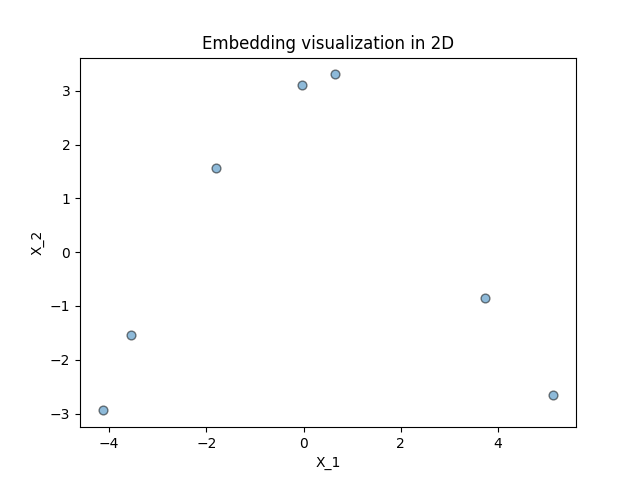

In [8]:
# define model
model_name = "bert-base-uncased"

# define the tokenizer and the model
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)
bert_sent_numpy_array, bert_low_dim= create_sentence_embedding(input_text_lst_news, bert_model, bert = True)
plot_2D(bert_low_dim[:,0], bert_low_dim[:,1], input_text_lst_news)


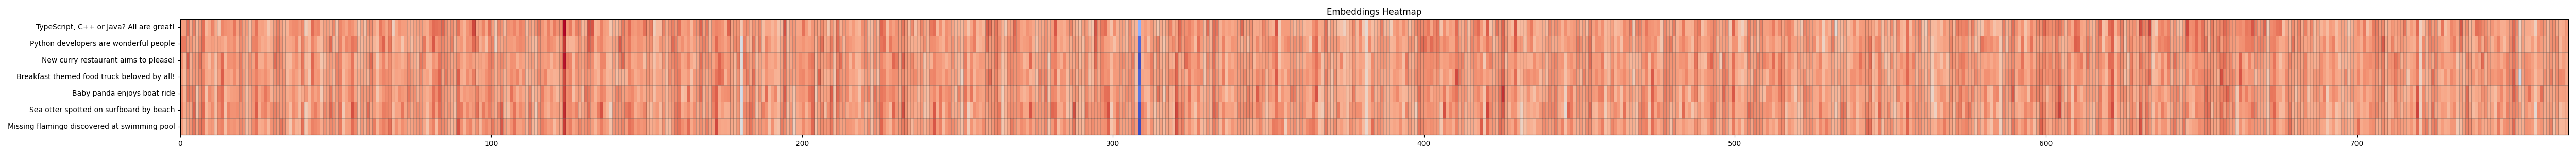

In [10]:

y_labels = input_text_lst_news

# Plot the heatmap
plot_heatmap(bert_sent_numpy_array, y_labels = y_labels, title = "Embeddings Heatmap")


In [11]:
def compare(embeddings: np.array, idx1: int, idx2: int) -> float:
    """A function to compute cosine similarity between two embedding vectors

    Args:
        embeddings (np.array): An array of embeddings
        idx1 (int): Index of the first embedding
        idx2 (int): index of the second embedding

    Returns:
        int: The distance between the two embeddings
    """
    item1 = embeddings[idx1, :].reshape(1, -1)
    item2 = embeddings[idx2, :].reshape(1, -1)
    distance = cosine_similarity(item1, item2)
    return distance.item()


In [12]:
compare(bert_sent_numpy_array, 5, 6)


0.6930423378944397

## Sentence embedding with SentenceTransformer

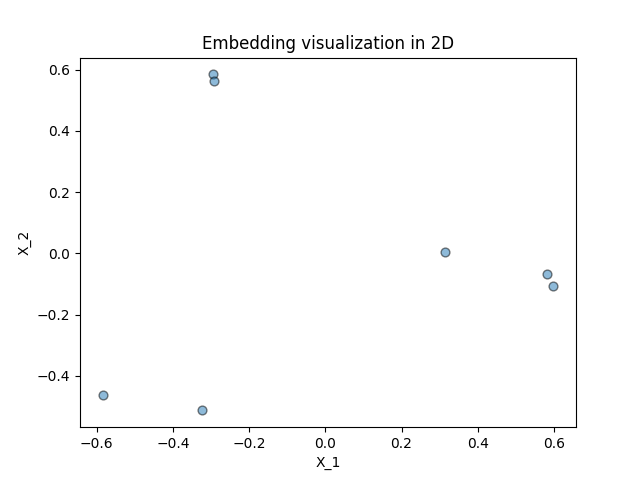

In [32]:
model = SentenceTransformer("all-mpnet-base-v2")
# model = SentenceTransformer('all-MiniLM-L6-v2')
_, sent_low_dim= create_sentence_embedding(input_text_lst_news, model, bert = False)
plot_2D(sent_low_dim[:,0], sent_low_dim[:,1], input_text_lst_news)


## Mistral Embedding

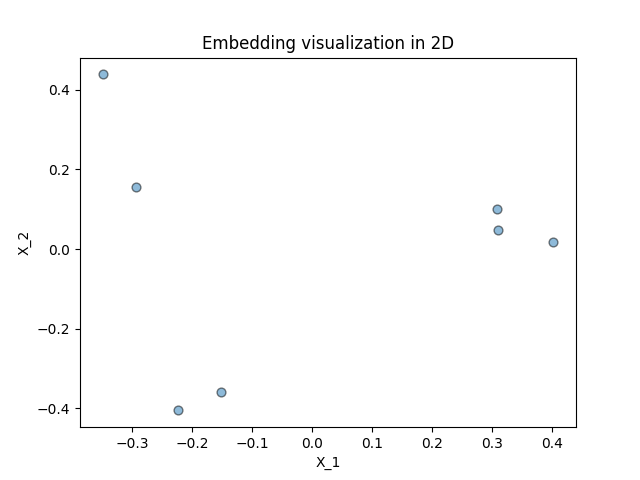

In [33]:
client = MistralClient(api_key=mistral_api_key)

embeddings_response = client.embeddings(
      model="mistral-embed",
      input=input_text_lst_news,
  )

mistral_embed_list = []
for i in range(len(embeddings_response.data)):
    mistral_embed_list.append(embeddings_response.data[i].embedding)
mistral_concatenated_embed_array = np.concatenate(mistral_embed_list).reshape(len(input_text_lst_news), -1)

PCA_model = PCA(n_components=2)
PCA_model.fit(mistral_concatenated_embed_array)
mistral_low_dim_array = PCA_model.transform(mistral_concatenated_embed_array)
plot_2D(mistral_low_dim_array[:,0], mistral_low_dim_array[:,1], input_text_lst_news)


In [6]:
# from embed_sources import create_sentence_embedding
# mistral_model="mistral-embed"
# m_high_embed, m_low_embed = create_sentence_embedding(input_text = input_text_lst_news,model = mistral_model, mistral = True)
# plot_2D(m_low_embed[:,0], m_low_embed[:,1], input_text_lst_news)


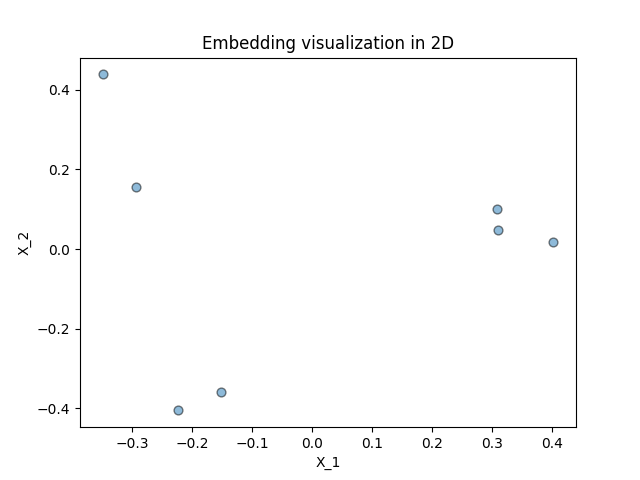

In [7]:
plot_2D(m_low_embed[:,0], m_low_embed[:,1], input_text_lst_news)


## Openai Sentence embedding

In [15]:
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_embedding(text: str, model="text-similarity-davinci-001", **kwargs) -> List[float]:

    # replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")

    response = openai.embeddings.create(input=[text], model=model, **kwargs)

    return response.data[0].embedding


@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_embeddings(
    list_of_text: List[str], model="text-similarity-babbage-001", **kwargs
) -> List[List[float]]:
    assert len(list_of_text) <= 2048, "The batch size should not be larger than 2048."

    # replace newlines, which can negatively affect performance.
    list_of_text = [text.replace("\n", " ") for text in list_of_text]

    data = openai.embeddings.create(input=list_of_text, model=model, **kwargs).data
    embed_list = [d.embedding for d in data]
    embed_array = np.array(embed_list)

    # Convert to 2-dimensional vector to be able to visualize the embeddings
    PCA_model = PCA(n_components=2)
    PCA_model.fit(embed_array)
    sent_low_dim_array = PCA_model.transform(embed_array)
    return embed_array, sent_low_dim_array

    # embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191


In [16]:
# openai.api_key = os.getenv("OPENAI_API_KEY")
_, oai_low_dim_response = get_embeddings(input_text_lst_news)


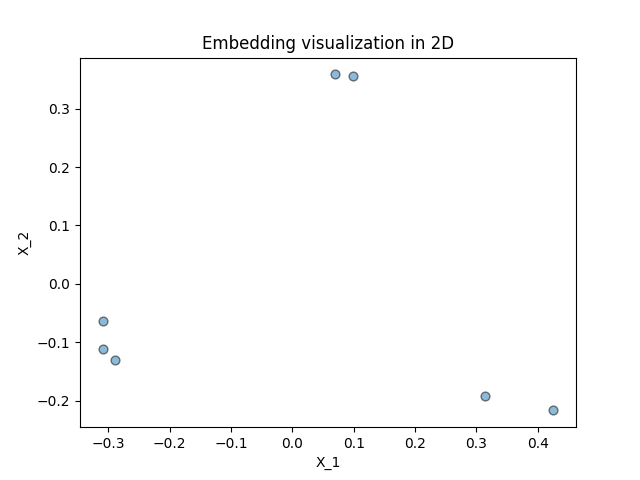

In [17]:
plot_2D(oai_low_dim_response[:,0], oai_low_dim_response[:,1], input_text_lst_news)


## Cohere Sentence Embeddings

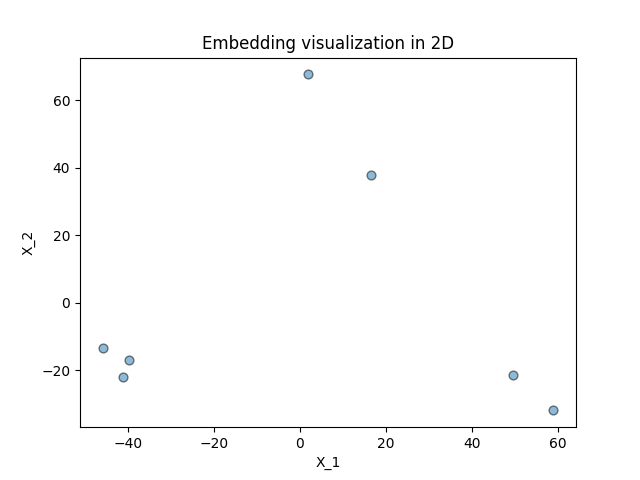

In [18]:
cohere_emebed = co.embed(texts=input_text_lst_news,
               model='embed-english-v2.0').embeddings
cohere_emebed_array = np.array(cohere_emebed)
# Convert to 2-dimensional vector to be able to visualize the embeddings
PCA_model = PCA(n_components=2)
PCA_model.fit(cohere_emebed_array)
cohere_low_dim_array = PCA_model.transform(cohere_emebed_array)
cohere_low_dim_array.shape
plot_2D(cohere_low_dim_array[:,0], cohere_low_dim_array[:,1], input_text_lst_news)


## Sentence Embedding with Gemini

In [19]:
# list the embedding model from Gemini
for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)


models/embedding-001

In [21]:
gmodel = "models/embedding-001"
def gembed_fn(model, input_text: List[str]) -> np.array:
    embed_list = []
    for text in input_text:
        # set the task type to semantic_similarity
        embedding = genai.embed_content(model = model, content = text,
        task_type = "semantic_similarity")["embedding"]
        embed_list.append(embedding)
    embed_array = np.array(embed_list)
     # Convert to 2-dimensional vector to be able to visualize the embeddings
    PCA_model = PCA(n_components=2)
    PCA_model.fit(embed_array)
    sent_low_dim_array = PCA_model.transform(embed_array)
    return embed_array, sent_low_dim_array


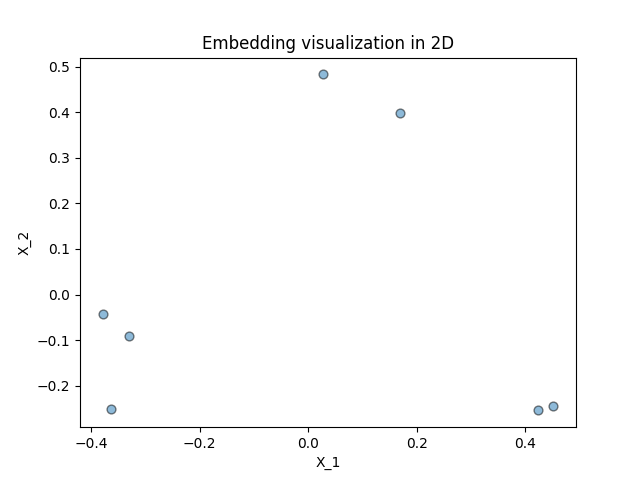

In [22]:
_, glow_dim_response = gembed_fn(gmodel, input_text_lst_news)
plot_2D(glow_dim_response[:,0], glow_dim_response[:,1], input_text_lst_news)


In [24]:
import numpy as np

# Create a list of lists
list_of_lists = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

# Concatenate the list of lists
concatenated_array = np.concatenate(list_of_lists)

print(concatenated_array)


[1 2 3 4 5 6 7 8 9]

In [16]:
type(embeddings_response.data[0].embedding)


list

In [18]:
len(embeddings_response.data)


7

In [10]:
print(embeddings_response)


EmbeddingResponse(
    id='embd-f6ab86b9020742718dce5089ae4a5af8',
    object='list',
    data=[
        EmbeddingObject(
            object='embedding',
            embedding=[
                -0.029815673828125,
                -0.001209259033203125,
                0.0283203125,
                -0.017608642578125,
                -0.005496978759765625,
                -0.00325775146484375,
                0.0207672119140625,
                -0.021087646484375,
                -0.01055145263671875,
                -0.027587890625,
                -0.06085205078125,
                0.048980712890625,
                -0.0150146484375,
                -0.01291656494140625,
                -0.03851318359375,
                0.0301666259765625,
                -0.0017871856689453125,
                0.00775146484375,
                0.03948974609375,
                -0.01904296875,
                -0.00506591796875,
                -0.03350830078125,
                -0.048828125,
                -0.00986480712890625,
                0.0027675628662109375,
                -0.0095977783203125,
                -0.0220489501953125,
                -0.0650634765625,
                -0.032073974609375,
                -0.02642822265625,
                -0.0202484130859375,
                -0.00782012939453125,
                -0.031768798828125,
                -0.04034423828125,
                0.016387939453125,
                -0.0204010009765625,
                -0.0157928466796875,
                0.0023746490478515625,
                0.0101470947265625,
                -0.0198211669921875,
                -0.0031909942626953125,
                -0.04925537109375,
                0.0196990966796875,
                -0.01006317138671875,
                -0.005096435546875,
                -0.0248260498046875,
                -0.00888824462890625,
                -0.0303802490234375,
                0.00867462158203125,
                -0.05419921875,
                0.0033092498779296875,
                0.034027099609375,
                0.0167236328125,
                -0.01049041748046875,
                0.00530242919921875,
                0.01122283935546875,
                0.01377105712890625,
                -0.012115478515625,
                -0.06451416015625,
                0.071533203125,
                -0.0909423828125,
                0.0218505859375,
                -0.0328369140625,
                0.00768280029296875,
                0.005161285400390625,
                0.044281005859375,
                0.0099334716796875,
                -0.0570068359375,
                -0.00505828857421875,
                0.011566162109375,
                0.05938720703125,
                0.0153045654296875,
                -0.006359100341796875,
                0.041168212890625,
                -0.036285400390625,
                -0.047393798828125,
                0.01531982421875,
                0.0255126953125,
                0.0367431640625,
                0.0027561187744140625,
                0.027099609375,
                0.01325225830078125,
                0.0328369140625,
                -0.0278778076171875,
                0.0213623046875,
                0.01397705078125,
                0.034454345703125,
                -0.039886474609375,
                -0.0160369873046875,
                0.06524658203125,
                0.06634521484375,
                0.01166534423828125,
                0.01145172119140625,
                -0.046234130859375,
                0.02960205078125,
                0.0218048095703125,
                -0.041534423828125,
                -0.0369873046875,
                -0.006465911865234375,
                0.01197052001953125,
                0.049346923828125,
                -7.969141006469727e-05,
                0.07159423828125,
                -0.0013866424560546875,
                0.0312347412109375,
                -0.0078277587890625,
                -0.00

In [ ]:
mistra_embeddings
